# Russia motherland map

В этой тетрадке описывается создание интерактивной карты России для  ....

## Подготовка карты
При подготовке карты мы будем использовать код, который уже кто-то заботливо написал для нас. Будем  честно блюсти авторские права и признаемся что и откуда было позаимствовано. Возможно, карма будет благосклонна ко мне, и кто-нибудь когда-нибудь честно признается, что взял мой код для своей работы и поставит ссылку. 

Саму по себе карту мы заберём из репозитория, расположенного по ссылке: https://github.com/Sobach/R.rus.map.zoom.
К сожалению, в этом репозитории хорош только рисунок. Сама по себе карта сделана плоховато. В 2000-х годах произошло объединение ряда маленьких субъектов в более крупные. Автор карты попытался учесть это и придать карте возможность изменяться в плане субъектов в зависимости от того какие данные идут на вход. Так, например, если у нас есть данные по Красноярскому краю, то на карте будет рисоваться Красноярский край. Если у нас есть данные по Красноярскому краю, Таймырскому АО и Эвенкийскому АО, которые были объединены в Красноярский край, то нарисуются они. 

В связи с моими кривыми руками из-за этой интерактивности возникла куча проблем. Поэтому я решил взять из репозитория только шикарную прорисовку карты с выделением европейской части, а саму по себе её собрать с нуля.

В интернете существует огромное количество баз с географическими данным, из которых можно скачать данные с географическими координатами самых разных объектов. Мы будем пользоваться следующими двумя источниками:

* http://www.naturalearthdata.com/downloads/10m-cultural-vectors/   отсюда мы возьмём файл с административным дроблением для всего мира admin_1 – States, Provinces. Дробление России в этой базе устаревшее.
* http://www.gadm.org/country отсюда возьмём файл с административным дроблением России. Тут оно няшное.

В представленных базах карты храняться в самых разных форматах. Мы будем использовать формат shapefile.

In [1]:
# Подключаем немножечко пакетов
library('ggplot2')
library('RColorBrewer')
library('rgdal')  # Для чтения .shp файлов и работы с ними (readOGR)
library('dplyr')


Loading required package: sp
rgdal: version: 1.2-5, (SVN revision 648)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 1.11.3, released 2015/09/16
 Path to GDAL shared files: /usr/share/gdal/1.11
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-4 

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Подгружаем загруженную нами в рабочую директорию карту с административным разделением России. Превращаем карту в dataframe, который будет пригоден для её прорисовки в ggplot2

In [2]:
rus.map <- readOGR("RUS_adm_shp/RUS_adm1.shp")
rudf <- fortify(rus.map)

OGR data source with driver: ESRI Shapefile 
Source: "RUS_adm_shp/RUS_adm1.shp", layer: "RUS_adm1"
with 85 features
It has 12 fields


Regions defined for each Polygons


Посмотрим на наш datafeame. В колонках находятся: долгота, широта, порядок, в котором будет проводиться граница региона, неизведанная колонка с всеобъемлющим FALSE, номера кусочков региона (если они есть, а мы специально попытались их избежать), id региона, группа региона. 

In [3]:
head(rudf)

long,lat,order,hole,piece,id,group
39.64795,45.16420,1,FALSE,1,0,0.1
39.68002,45.15558,2,FALSE,1,0,0.1
39.71161,45.15827,3,FALSE,1,0,0.1
39.74795,45.16826,4,FALSE,1,0,0.1
39.78126,45.16210,5,FALSE,1,0,0.1
39.80061,45.15137,6,FALSE,1,0,0.1


Изобразим всё это чудо на карте с помощью ggplot2!

Warning message:
“`axis.ticks.margin` is deprecated. Please set `margin` property  of `axis.text` instead”

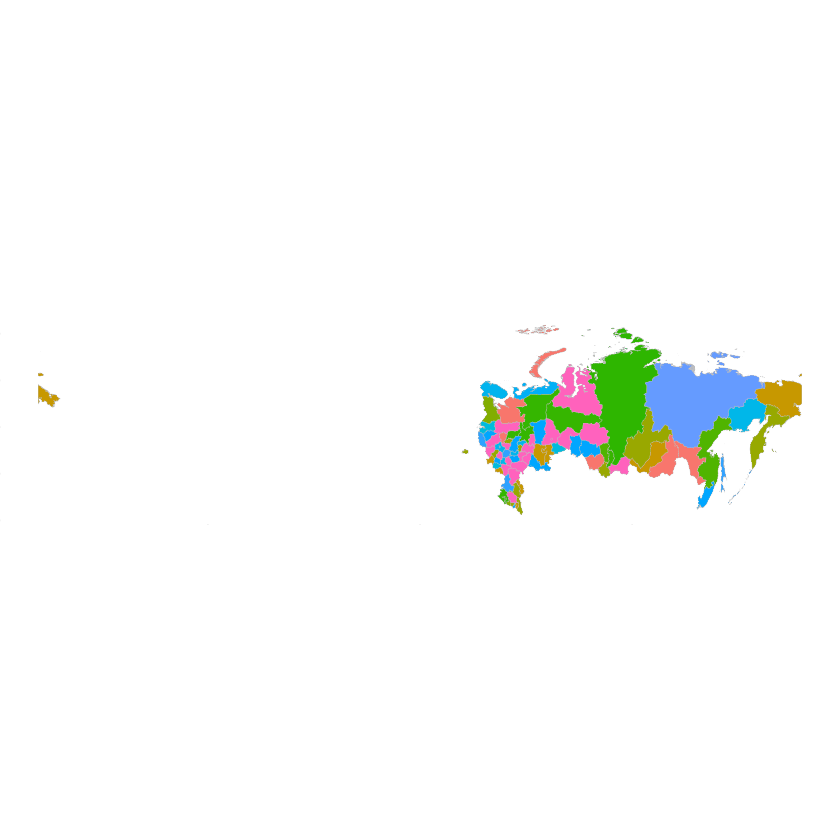

In [4]:
p <- ggplot() +
            # данные    по оси х долгота, по y широта, границы проводятся по колонке group. Заливка аналогично. 
    geom_polygon(data = rudf, mapping = aes(x=long, y=lat, group = group, fill = group),
           # сами по себе границы будем рисовать серым с толщиной 0.1
           colour= 'grey',size = 0.1 )+ 
           # зафиксируем размер координатной сетки, чтобы не было искажений   
           coord_fixed(2.2) +
           # настроим стиль карты
    theme(axis.line=element_blank(),              # настраиваем координатные оси (удаляем их)
          axis.text.x=element_blank(),            # 
          axis.text.y=element_blank(),            # 
          axis.title.x=element_blank(),           # 
          axis.title.y=element_blank(),           #
          legend.position = 'none',               # удаляем легенду
          panel.spacing = unit(c(0,0,0,0), 'cm'), # убираем отступы и настраиваем кое-какие расстояния
          axis.ticks.margin = unit(0, 'cm'),      #
          axis.ticks.length = unit(0.001, 'cm'),  #
          plot.margin = unit(c(0,0,0,0), 'cm'),   #
          panel.grid = element_blank(),           # убираем решётку и фон
          panel.background = element_blank()      #
         ) +
    labs(x=NULL, y = NULL)

p

Первое же, что к нам приходит на ум и не отпускает это Чукотка, которая оказалась на линии перемены дат. Узнаем id чукотки в rus.map@data и сдвинем нужный нам кусок Чукотки в правильное полушарие.

In [5]:
head(rus.map@data,3)

,ID_0,ISO,NAME_0,ID_1,NAME_1,HASC_1,CCN_1,CCA_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1
0,188,RUS,Russia,1,Adygey,RU.AD,0,0,Respublika,Republic,Республика Адыгея,Adygea|Adygeya|Adygheya|Republic of Adygeya|Adygeyskaya A.Obl.|Respublika Adygeya
1,188,RUS,Russia,2,Altay,RU.AL,0,0,Kray,Territory,Алтайский край,Altayskiy Kray
2,188,RUS,Russia,3,Amur,RU.AM,0,0,Oblast,Region,Амурская область,Amurskaya Oblast


Конец Чукотки расположен не там! Найдём его и перенесём на 360 градусов вправо. 

In [6]:
tail(rudf[rudf$id==11,])

,long,lat,order,hole,piece,id,group
340069,-179.9984,64.95677,106145,FALSE,445,11,11.445
340070,-179.9984,69.11927,106146,FALSE,446,11,11.446
340071,-180.0000,69.11927,106147,FALSE,446,11,11.446
340072,-180.0000,69.12032,106148,FALSE,446,11,11.446
340073,-179.9984,69.12032,106149,FALSE,446,11,11.446
340074,-179.9984,69.11927,106150,FALSE,446,11,11.446


In [7]:
a <- rudf[rudf$id == 11,][rudf[rudf$id == 11,]$long < 100,]$long + 360
rudf[rudf$id == 11,][rudf[rudf$id == 11,]$long < 100,]$long <- a

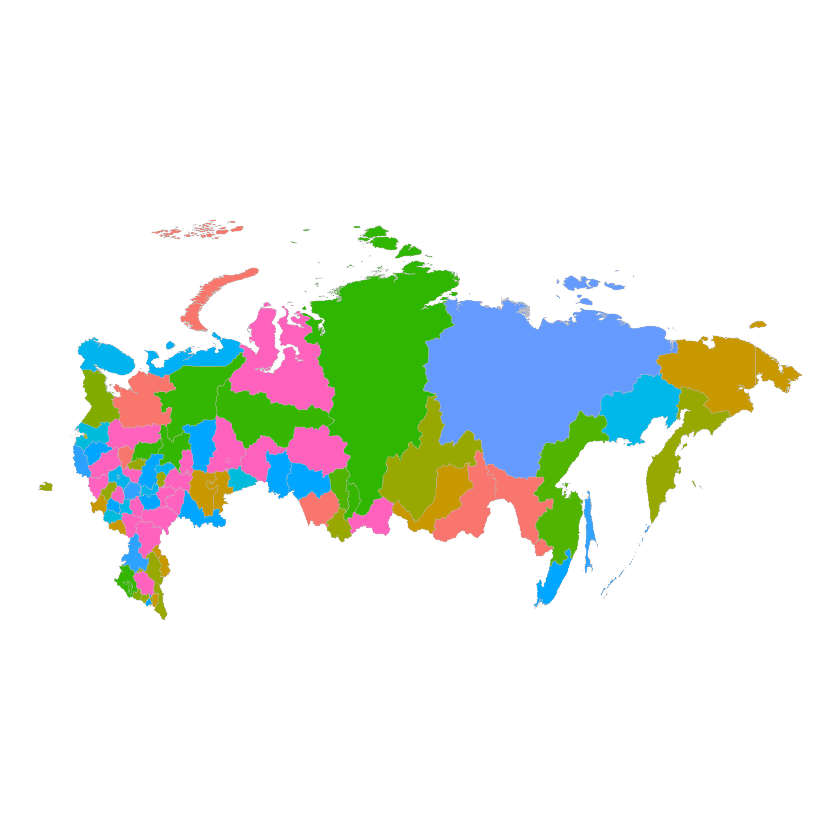

In [8]:
p <- ggplot() +
    geom_polygon(data = rudf, mapping = aes(x=long, y=lat, group = group, fill = group),
                 colour= 'grey',size = 0.1 )+ coord_fixed(2.2) +
    theme(axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.title.x=element_blank(),
          axis.title.y=element_blank(),          
          legend.position = 'none',
          panel.spacing = unit(c(0,0,0,0), 'cm'),
          #axis.ticks.margin = unit(0, 'cm'),
          axis.ticks.length = unit(0.001, 'cm'),
          plot.margin = unit(c(0,0,0,0), 'cm'),
          panel.grid = element_blank(),
          panel.background = element_blank()
         ) +
    labs(x=NULL, y = NULL)
p

Отлично! Пришло время присоединить Крым. Скачиваем с [naturalearthdata](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/) данные по провинциям для различных стран: "Admin 1 – States, Provinces". Кладём их в рабочую директорию и подгружаем.

In [9]:
wld <- readOGR("ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")

OGR data source with driver: ESRI Shapefile 
Source: "ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp", layer: "ne_10m_admin_1_states_provinces"
with 4647 features
It has 59 fields


Находим в данных интересующие нас объекты, приведём их к порядочному виду и посмотрим на них.

In [10]:
Uk_map <- wld[wld$admin == "Ukraine", ]
Crimea_map <- Uk_map[Uk_map$name == "Crimea",]
Sevastopol_map <- Uk_map[Uk_map$name == 'Sevastopol',]

Crimea_df <- fortify(Crimea_map)
Sevastopol_df <- fortify(Sevastopol_map)
head(Crimea_df)

Regions defined for each Polygons
Regions defined for each Polygons


long,lat,order,hole,piece,id,group
33.75521,46.19337,1,FALSE,1,4352,4352.1
33.80188,46.20271,2,FALSE,1,4352,4352.1
33.84622,46.19571,3,FALSE,1,4352,4352.1
33.89289,46.17704,4,FALSE,1,4352,4352.1
33.94423,46.15370,5,FALSE,1,4352,4352.1
33.99090,46.13036,6,FALSE,1,4352,4352.1


Присвоим новы субъектам правильный ID, который впоследствии мы сможем использовать при прорисовке. Добавим этот ID в наш списочек с субъектами. 

In [11]:
Crimea_new_id <- rep(100,length(Crimea_df$id))
Crimea_new_group <- rep(as.factor(100.1),length(Crimea_df$id))
Crimea_df$id = Crimea_new_id
Crimea_df$group = Crimea_new_group

Sevastopol_new_id <- rep(101,length(Sevastopol_df$id))
Sevastopol_new_group <- rep(as.factor(101.1),length(Sevastopol_df$id))
Sevastopol_df$id = Sevastopol_new_id
Sevastopol_df$group = Sevastopol_new_group

tail(Crimea_df)

,long,lat,order,hole,piece,id,group
393,33.66045,46.14818,393,FALSE,1,100,100.1
394,33.67146,46.17295,394,FALSE,1,100,100.1
395,33.66162,46.21017,395,FALSE,1,100,100.1
396,33.67028,46.21811,396,FALSE,1,100,100.1
397,33.71573,46.19574,397,FALSE,1,100,100.1
398,33.75521,46.19337,398,FALSE,1,100,100.1


Посмотрим на новые субъекты.

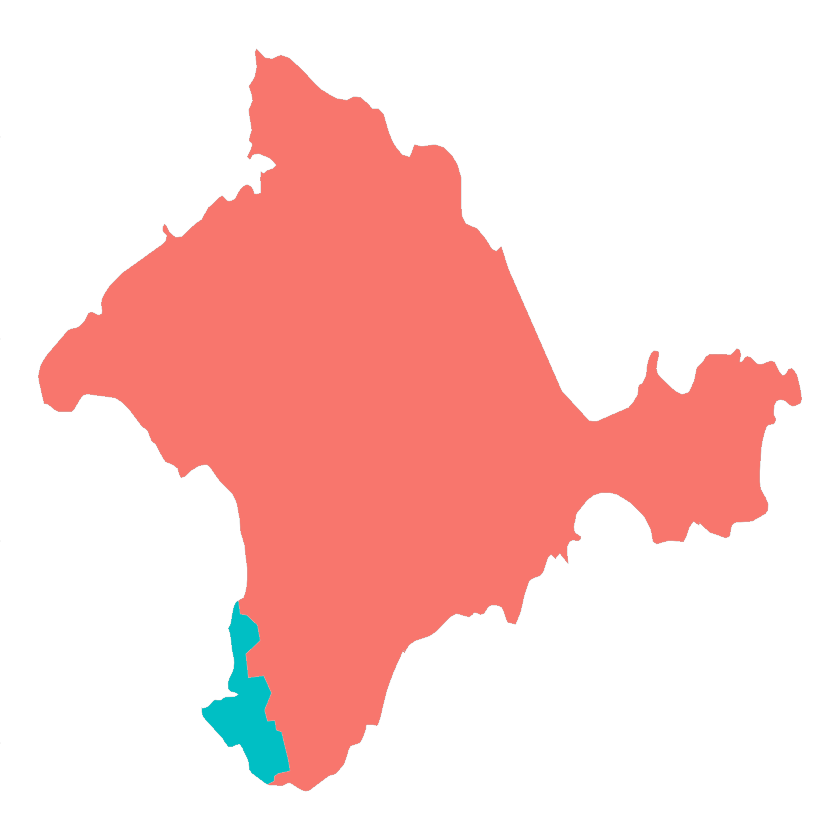

In [12]:
newsubj_df <- rbind(Crimea_df,Sevastopol_df)

p <- ggplot() +
    geom_polygon(data = newsubj_df, mapping = aes(x=long, y=lat, group = group, fill = group),
                 colour= 'grey',size = 0.1 )+ coord_fixed(2.2) +
    theme(axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.title.x=element_blank(),
          axis.title.y=element_blank(),          
          legend.position = 'none',
          panel.spacing = unit(c(0,0,0,0), 'cm'),
          #axis.ticks.margin = unit(0, 'cm'),
          axis.ticks.length = unit(0.001, 'cm'),
          plot.margin = unit(c(0,0,0,0), 'cm'),
          panel.grid = element_blank(),
          panel.background = element_blank()
         ) +
    labs(x=NULL, y = NULL) 
p

Добавим новые субъекты в общую табличку и ещё разочек посмотрим на карту

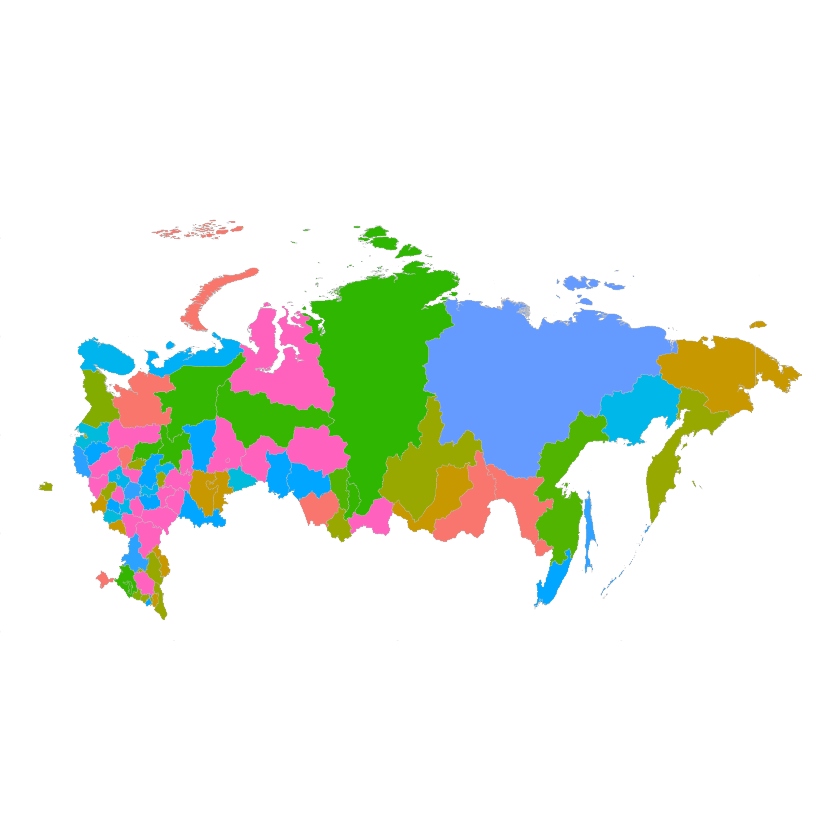

In [13]:
russia_df <- rbind(rudf,Crimea_df,Sevastopol_df)

p <- ggplot() +
    geom_polygon(data = russia_df, mapping = aes(x=long, y=lat, group = group, fill = group),
                 colour= 'grey',size = 0.1 )+ coord_fixed(2.2) +
    theme(axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.title.x=element_blank(),
          axis.title.y=element_blank(),          
          legend.position = 'none',
          panel.spacing = unit(c(0,0,0,0), 'cm'),
          #axis.ticks.margin = unit(0, 'cm'),
          axis.ticks.length = unit(0.001, 'cm'),
          plot.margin = unit(c(0,0,0,0), 'cm'),
          panel.grid = element_blank(),
          panel.background = element_blank()
         ) +
    labs(x=NULL, y = NULL)
p

Карта готова к дальнейшему использванию. Сохраним её и список сопоставлений субъектов с ID. Придётся немного подправить этот список руками, чтобы он соответствовал подгружаемому с данными датафрейму.

In [42]:
subid <- data.frame('id' = rus.map@data[,4]-1,'NAME' = rus.map@data[,11])
newsub <- data.frame('id' = c(100,101),'NAME' = c('Республика Крым','г. Севастополь'))
subj_id <- rbind(subid,newsub)

In [61]:
saveRDS(russia_df, "russia_map.rds")
write.csv(subj_id,'subj_id.csv')

## После подгрузки

In [14]:
# Подгружаем координаты объектов для карты
russia_dff <- readRDS("russia_map.rds")

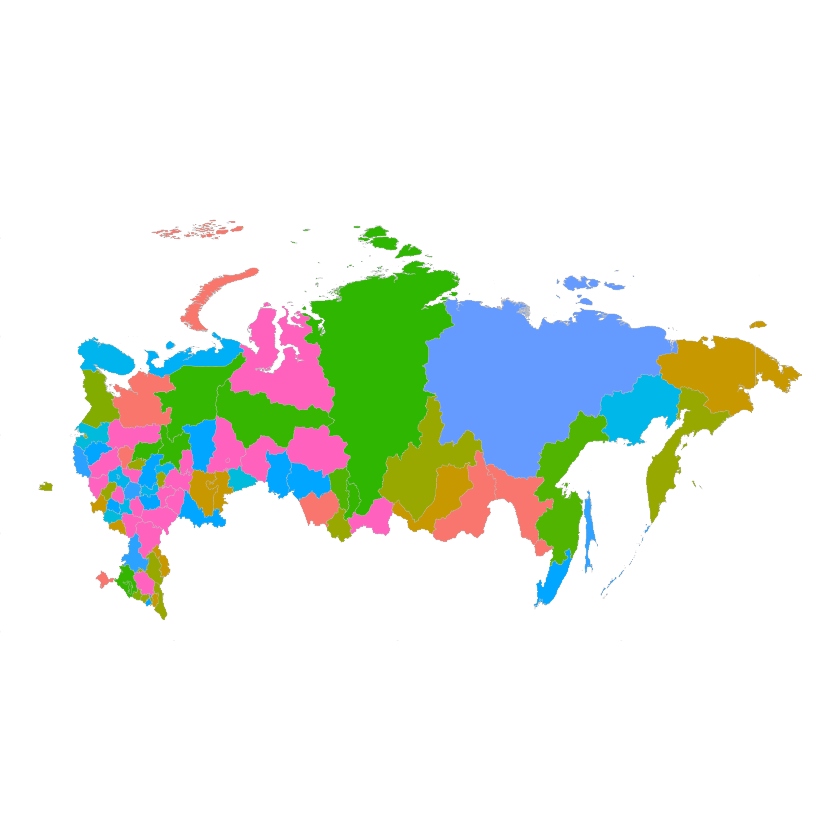

In [15]:
p <- ggplot() +
    geom_polygon(data = russia_dff, mapping = aes(x=long, y=lat, group = group, fill = group),
                 colour= 'grey',size = 0.1 )+ coord_fixed(2.2) +
    theme(axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.title.x=element_blank(),
          axis.title.y=element_blank(),          
          legend.position = 'none',
          panel.spacing = unit(c(0,0,0,0), 'cm'),
          #axis.ticks.margin = unit(0, 'cm'),
          axis.ticks.length = unit(0.001, 'cm'),
          plot.margin = unit(c(0,0,0,0), 'cm'),
          panel.grid = element_blank(),
          panel.background = element_blank()
         ) +
    labs(x=NULL, y = NULL)
p

## Прорисовка карты

Попробуем прорисовать карту для какого-нибудь одного датафрейма. Подгрузим все наши заготовочки и начинаем рисовать! Этот кусок кода не зависит от того, что было выше.

In [16]:
# Подгружаем таблицу с данными и таблицу с сопоставлением каждому субъекту его id
alldata <- read.csv('Prod_price_03_16_m.csv',sep=',',header=TRUE)
years <- gsub("[.]"," ",names(alldata)[-c(1,2,3,4)])
newnames <- c(names(alldata)[1:4],years) 
names(alldata) <- newnames

subj_id <- read.csv('subj_id.csv', header=T, encoding = 'UTF-8')

In [17]:
head(alldata,4)

X,X.1,X.2,X.3,январь 2003,февраль 2003,март 2003,апрель 2003,май 2003,июнь 2003,⋯,март 2016,апрель 2016,май 2016,июнь 2016,июль 2016,август 2016,сентябрь 2016,октябрь 2016,ноябрь 2016,декабрь 2016
Region_num,Region_name,Prod_num,Prod_name,1.00,2.00,3.00,4.00,5.00,6.00,⋯,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00
0,Российская Федерация,1,"Абонентская плата за неограниченный объем местных телефонных соединений, месяц",101.98,101.95,101.93,102.45,106.79,108.33,⋯,432.94,434.30,434.46,434.63,434.72,434.76,434.77,434.79,434.80,434.85
0,Российская Федерация,2,"Ацетилсалициловая кислота (Аспирин отечественный), 500 мг, 10 таблеток",1.48,1.48,1.49,1.50,1.50,1.50,⋯,6.43,6.46,6.40,6.41,6.39,6.40,6.40,6.43,6.45,6.43
0,Российская Федерация,3,"Бензин автомобильный марки АИ-92 (АИ-93 и т.п.), л",10.26,10.49,10.60,10.56,10.47,10.48,⋯,34.11,34.38,34.43,34.77,35.13,35.20,35.19,35.15,35.17,35.28


In [18]:
# список уникальных продуктов из тестового датафрейма
products <- unique(alldata$X.3)

In [19]:
# Выделяем какой-нибудь один продукт 
curent_data <- alldata[alldata$X.3 == products[42],][-1,]
stat <- data.frame( )
stat <- data.frame('NAME' = as.vector(curent_data$X.1),'TEST_DATA'=curent_data$'январь 2003')
head(stat,3)

NAME,TEST_DATA
Алтайский край,3169.12
Амурская область,4049.80
Архангельская область,3407.34


In [20]:
map.data <- merge(stat,subj_id,by='NAME')
head(map.data)

NAME,TEST_DATA,ID
Алтайский край,3169.12,1
Амурская область,4049.80,2
Архангельская область,3407.34,3
Астраханская область,3820.70,4
Белгородская область,3099.21,6
Брянская область,2721.11,7


Подготовим по конкретному продукту датафрейм для карты. Команда merge вносила в таблицу разброд. Колонка order, отвечающая за порядок точек в разграничивании субъектов перемешивалась и всё шло из ряда вон плохо. Поэтому я прописал слияние датафреймов вручную .

![](http://renotes.ru/content/public/upload/velosiped-iz-kostyley_0_o.jpg)

In [21]:
ids <- unique(russia_df$id)

In [22]:
all_names <- c()
all_numbers <- c()

for(i in 1:length(ids)){
    current_df <- russia_df[russia_df$id == ids[i],]
    n <- nrow(current_df)
    new_elements <- map.data[map.data$ID == ids[i],]
    new_name <- rep(new_elements[1,1],n)
    new_number <- rep(new_elements[1,2],n)
    all_names <- c(all_names,as.vector(new_name))
    all_numbers <- c(all_numbers,as.vector(new_number))
    }

map.df <- mutate(russia_df,'NAME' = all_names,'DATA' = all_numbers)

In [23]:
tail(russia_df[russia_df$id == 34,])

,long,lat,order,hole,piece,id,group
909028,83.49375,70.55833,309161,FALSE,1392,34,34.1392
909029,83.49583,70.55833,309162,FALSE,1392,34,34.1392
909030,83.49658,70.55808,309163,FALSE,1392,34,34.1392
909031,83.49740,70.55782,309164,FALSE,1392,34,34.1392
909032,83.49740,70.55677,309165,FALSE,1392,34,34.1392
909033,83.49583,70.55625,309166,FALSE,1392,34,34.1392


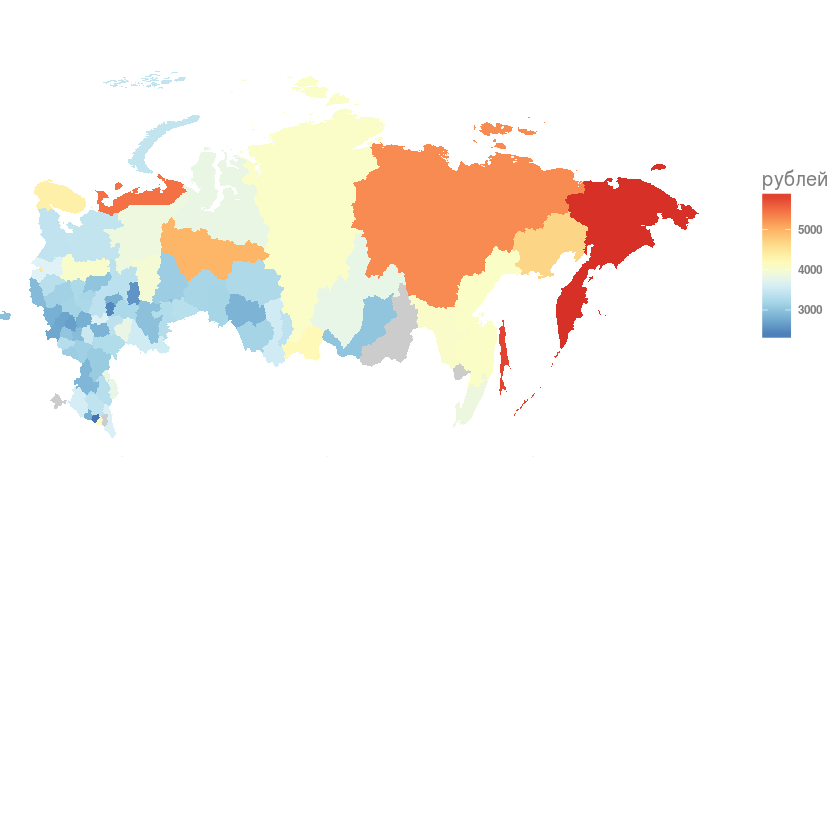

In [44]:
# Выбор градиента заливки
palette <- colorRampPalette(brewer.pal(11, 'RdYlBu')[10:2])
# palette <- colorRampPalette(brewer.pal(9, 'Blues')[3:9])
# palette <- colorRampPalette(brewer.pal(9, 'YlOrRd')[2:10])

# Другие варианты палеток
# library(RColorBrewer)
# par(mar = c(0, 4, 0, 0))
# display.brewer.all()

p <- ggplot() +
    geom_polygon(data = map.df, mapping = aes(x=long, y=lat, group = group, fill = DATA),
                 colour= 'grey',size = 0.01 )+
    scale_fill_gradientn(colours = palette(100), na.value='grey80', name = 'рублей')+
    coord_fixed(2.2) +
    theme(axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.title.x=element_blank(),
          axis.title.y=element_blank(),          
          legend.position = 'right',
          legend.text = element_text(colour = 'grey50',size = 7),
          legend.title = element_text(colour = 'grey50',size = 12),
          panel.spacing = unit(c(0,0,0,0), 'cm'),
          axis.ticks.length = unit(0.001, 'cm'),
          plot.margin = unit(c(-7,0,0,-0.8), 'cm'),
          panel.grid = element_blank(),
          panel.background = element_blank()
         ) +
    labs(x=NULL, y = NULL) 
p

# Выделение европейской части

Код для этого берём всё из того же репозитория.

Checking rgeos availability: TRUE
Loading required package: maps
General Polygon Clipper Library for R (version 1.5-5)
	Type 'class ? gpc.poly' for help


ERROR: Error in print.ggplot(p2, vp = regular): object 'regular' not found


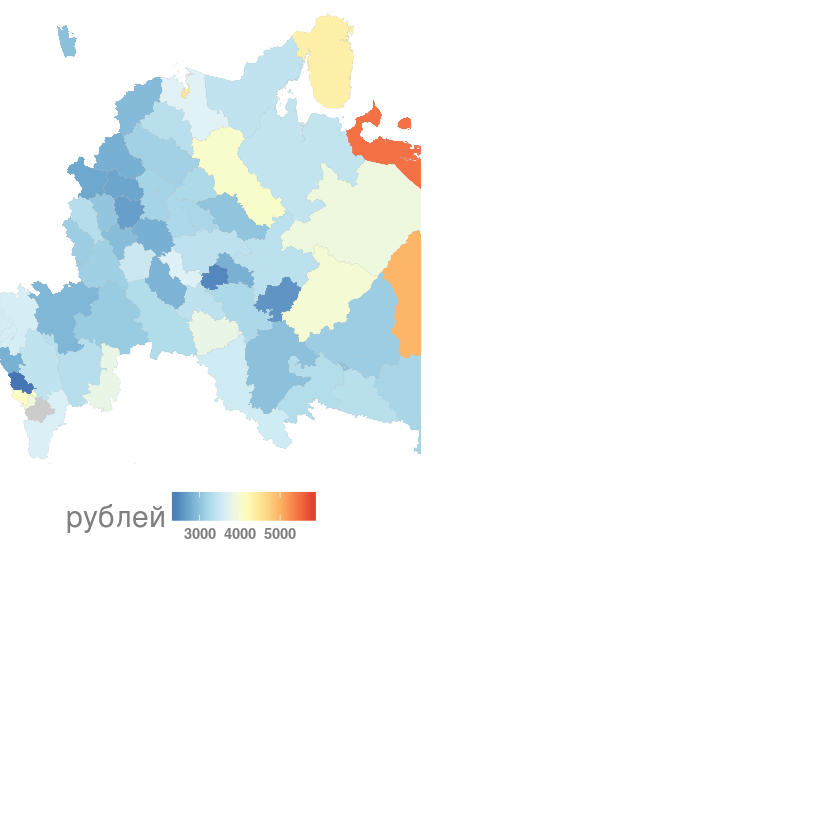

In [35]:
library('grid')
library('sp')
library('maptools') 
library('mapproj')
library('gpclib')

# Всякие разные заголовки для нашей карты 
#text.title <- 'Что-то там для чего-то там в таком-то году'

# Деление карты на две части - приближенную и уменьшенную
p1 <- p + coord_map(projection = 'azequidist', 
                    orientation = c(90, -10, 105), 
                    xlim = c(26, 57), 
                    ylim=c(47.5, 67))
p2 <- p + coord_map(projection = 'azequidist', 
                    orientation = c(90, 5, 95), 
                    xlim = c(79, 155), 
                    ylim=c(47, 90))
p2 <- p2 + theme(legend.position = 'bottom',
                 legend.text = element_text(colour = 'grey50'),
                 legend.title = element_text(colour = 'grey50', 
                                             size = 15)
                )


# Setting up final graph. regions
#title = viewport(x = .5, y = .86, width = .5, height = .03)
zoomed = viewport(x = .25, y = .47, width = .5, height = .9)
#regular = viewport(x = .75, y = .47, width = .5, height = .9)

# Прорисовка
print(p1, vp=zoomed)
print(p2, vp=regular)

#grid.text(text.title, gp=gpar(fontsize=20, col='grey50', fontface='bold'), vp = title)


#grid.lines(x = c(.5, .5), y = c(.05, .8), gp=gpar(col='grey70'))


In [47]:
Sys.Date()

[1] "2017-04-15"

Хотим ещё ссылок на разные карты! 

* http://eriqande.github.io/rep-res-web/lectures/making-maps-with-R.html
* http://www.nickeubank.com/wp-content/uploads/2015/10/RGIS3_MakingMaps_part1_mappingVectorData.html
* http://www.kevjohnson.org/making-maps-in-r/